# Visualize UMAP for plate 3 based on top actin feature from final model

The top actin feature from the model is used to predict the failing heart state: `Cells_Intensity_IntegratedIntensityEdge_Actin`

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(arrow))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”
Warning message:
“package ‘arrow’ was built under R version 4.2.3”


In [2]:
# Set directory and file structure
umap_dir <- file.path("../../4.analyze_data/notebooks/UMAP/results")
plate3_name <- "localhost230405150001"
umap_file <- paste0("UMAP_", plate3_name, "_sc_feature_selected.tsv.gz")
umap_path <- file.path(umap_dir, umap_file)

output_fig_dir <- file.path("figures")

# Define output figure paths
output_umap_file <- file.path(
    output_fig_dir,
    paste0("UMAP_", plate3_name)
)

print(output_umap_file)

[1] "figures/UMAP_localhost230405150001"


In [3]:
# Load in the umap data
umap_df <- read.csv(umap_path, sep = "\t")

cell_count_df <- umap_df %>%
    dplyr::group_by(Metadata_Well) %>%
    dplyr::count()

umap_cp_df <- umap_df %>%
    dplyr::left_join(cell_count_df, by = "Metadata_Well")

# Print shape and head for UMAP dataframe
dim(umap_cp_df)
head(umap_cp_df)

[1] 20865    22

,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,⋯,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,UMAP0,UMAP1,n
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>
1,B,2,9,failing,rejected,DMSO,221.0468,137.1155,246.6028,109.2858,⋯,localhost230405150001,B02,1,1,6,6,f00,3.398841,2.7031803,470
2,B,2,9,failing,rejected,DMSO,690.5961,183.0678,716.1701,177.1322,⋯,localhost230405150001,B02,2,2,7,7,f00,-1.088180,0.4290003,470
3,B,2,9,failing,rejected,DMSO,626.5615,206.9237,623.9437,199.9064,⋯,localhost230405150001,B02,3,3,8,8,f00,-0.260282,0.9745665,470
4,B,2,9,failing,rejected,DMSO,559.4486,220.6882,528.6466,196.9556,⋯,localhost230405150001,B02,4,4,9,9,f00,1.834983,1.6082561,470
5,B,2,9,failing,rejected,DMSO,909.0199,247.6943,897.9660,253.6218,⋯,localhost230405150001,B02,5,5,10,10,f00,3.326914,2.8305938,470
6,B,2,9,failing,rejected,DMSO,330.7563,260.8621,341.5217,269.5020,⋯,localhost230405150001,B02,6,6,11,11,f00,4.204170,3.2994792,470


In [4]:
# Read the normalized Parquet file and select the required columns
actin_feature_df <- read_parquet("../../3.process_cfret_features/data/single_cell_profiles/localhost230405150001_sc_normalized.parquet") %>%
  select(Metadata_Well, Metadata_Site, Metadata_Nuclei_Number_Object_Number, Cells_Intensity_IntegratedIntensityEdge_Actin)

# Display the filtered dataframe
dim(actin_feature_df)
head(actin_feature_df)

[1] 20865     4

Metadata_Well,Metadata_Site,Metadata_Nuclei_Number_Object_Number,Cells_Intensity_IntegratedIntensityEdge_Actin
<chr>,<chr>,<int>,<dbl>
B02,f00,6,0.61768292
B02,f00,7,0.06306190
B02,f00,8,0.03923949
B02,f00,9,0.10835911
B02,f00,10,-0.57356821
B02,f00,11,0.27235549


In [5]:
# Ensure only the specific metadata columns are used for the join
metadata_cols <- c("Metadata_Well", "Metadata_Site", "Metadata_Nuclei_Number_Object_Number")

# Ensure these Metadata columns are character type, lowercase, and trimmed of whitespace in both dataframes
actin_feature_df <- actin_feature_df %>%
  mutate(across(metadata_cols, ~ str_trim(as.character(.), side = "both")))

umap_cp_df <- umap_cp_df %>%
  mutate(across(metadata_cols, ~ str_trim(as.character(.), side = "both")))

# Perform the join using the selected "Metadata" columns
combined_df <- umap_cp_df %>%
  left_join(actin_feature_df, by = metadata_cols)

# Remove columns ending with '.y' (duplicate columns from the join) and rename columns ending with '.x'
combined_df <- combined_df %>%
  select(-ends_with(".y")) %>%  # Remove columns ending with '.y'
  rename_with(~ gsub("\\.x$", "", .), ends_with(".x"))  # Rename columns ending with '.x' by removing the suffix

# Display the joined dataframe
dim(combined_df)
head(combined_df)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(metadata_cols)

  # Now:
  data %>% select(all_of(metadata_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


[1] 20865    23

,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,⋯,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,UMAP0,UMAP1,n,Cells_Intensity_IntegratedIntensityEdge_Actin
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,B,2,9,failing,rejected,DMSO,221.0468,137.1155,246.6028,109.2858,⋯,B02,1,1,6,6,f00,3.398841,2.7031803,470,0.61768292
2,B,2,9,failing,rejected,DMSO,690.5961,183.0678,716.1701,177.1322,⋯,B02,2,2,7,7,f00,-1.088180,0.4290003,470,0.06306190
3,B,2,9,failing,rejected,DMSO,626.5615,206.9237,623.9437,199.9064,⋯,B02,3,3,8,8,f00,-0.260282,0.9745665,470,0.03923949
4,B,2,9,failing,rejected,DMSO,559.4486,220.6882,528.6466,196.9556,⋯,B02,4,4,9,9,f00,1.834983,1.6082561,470,0.10835911
5,B,2,9,failing,rejected,DMSO,909.0199,247.6943,897.9660,253.6218,⋯,B02,5,5,10,10,f00,3.326914,2.8305938,470,-0.57356821
6,B,2,9,failing,rejected,DMSO,330.7563,260.8621,341.5217,269.5020,⋯,B02,6,6,11,11,f00,4.204170,3.2994792,470,0.27235549


In [6]:
# Filter the combined_df to exclude "drug_x" treatment (not included in manuscript)
# and remove TGFRi + Healthy (not included in original manuscript UMAP)
combined_df <- combined_df %>%
    dplyr::filter(
        Metadata_treatment != "drug_x" &
        !(Metadata_treatment == "TGFRi" & Metadata_cell_type == "healthy")
    )

# Display the dataframe
dim(combined_df)
head(combined_df)

[1] 14307    23

,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,⋯,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,UMAP0,UMAP1,n,Cells_Intensity_IntegratedIntensityEdge_Actin
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,B,2,9,failing,rejected,DMSO,221.0468,137.1155,246.6028,109.2858,⋯,B02,1,1,6,6,f00,3.398841,2.7031803,470,0.61768292
2,B,2,9,failing,rejected,DMSO,690.5961,183.0678,716.1701,177.1322,⋯,B02,2,2,7,7,f00,-1.088180,0.4290003,470,0.06306190
3,B,2,9,failing,rejected,DMSO,626.5615,206.9237,623.9437,199.9064,⋯,B02,3,3,8,8,f00,-0.260282,0.9745665,470,0.03923949
4,B,2,9,failing,rejected,DMSO,559.4486,220.6882,528.6466,196.9556,⋯,B02,4,4,9,9,f00,1.834983,1.6082561,470,0.10835911
5,B,2,9,failing,rejected,DMSO,909.0199,247.6943,897.9660,253.6218,⋯,B02,5,5,10,10,f00,3.326914,2.8305938,470,-0.57356821
6,B,2,9,failing,rejected,DMSO,330.7563,260.8621,341.5217,269.5020,⋯,B02,6,6,11,11,f00,4.204170,3.2994792,470,0.27235549


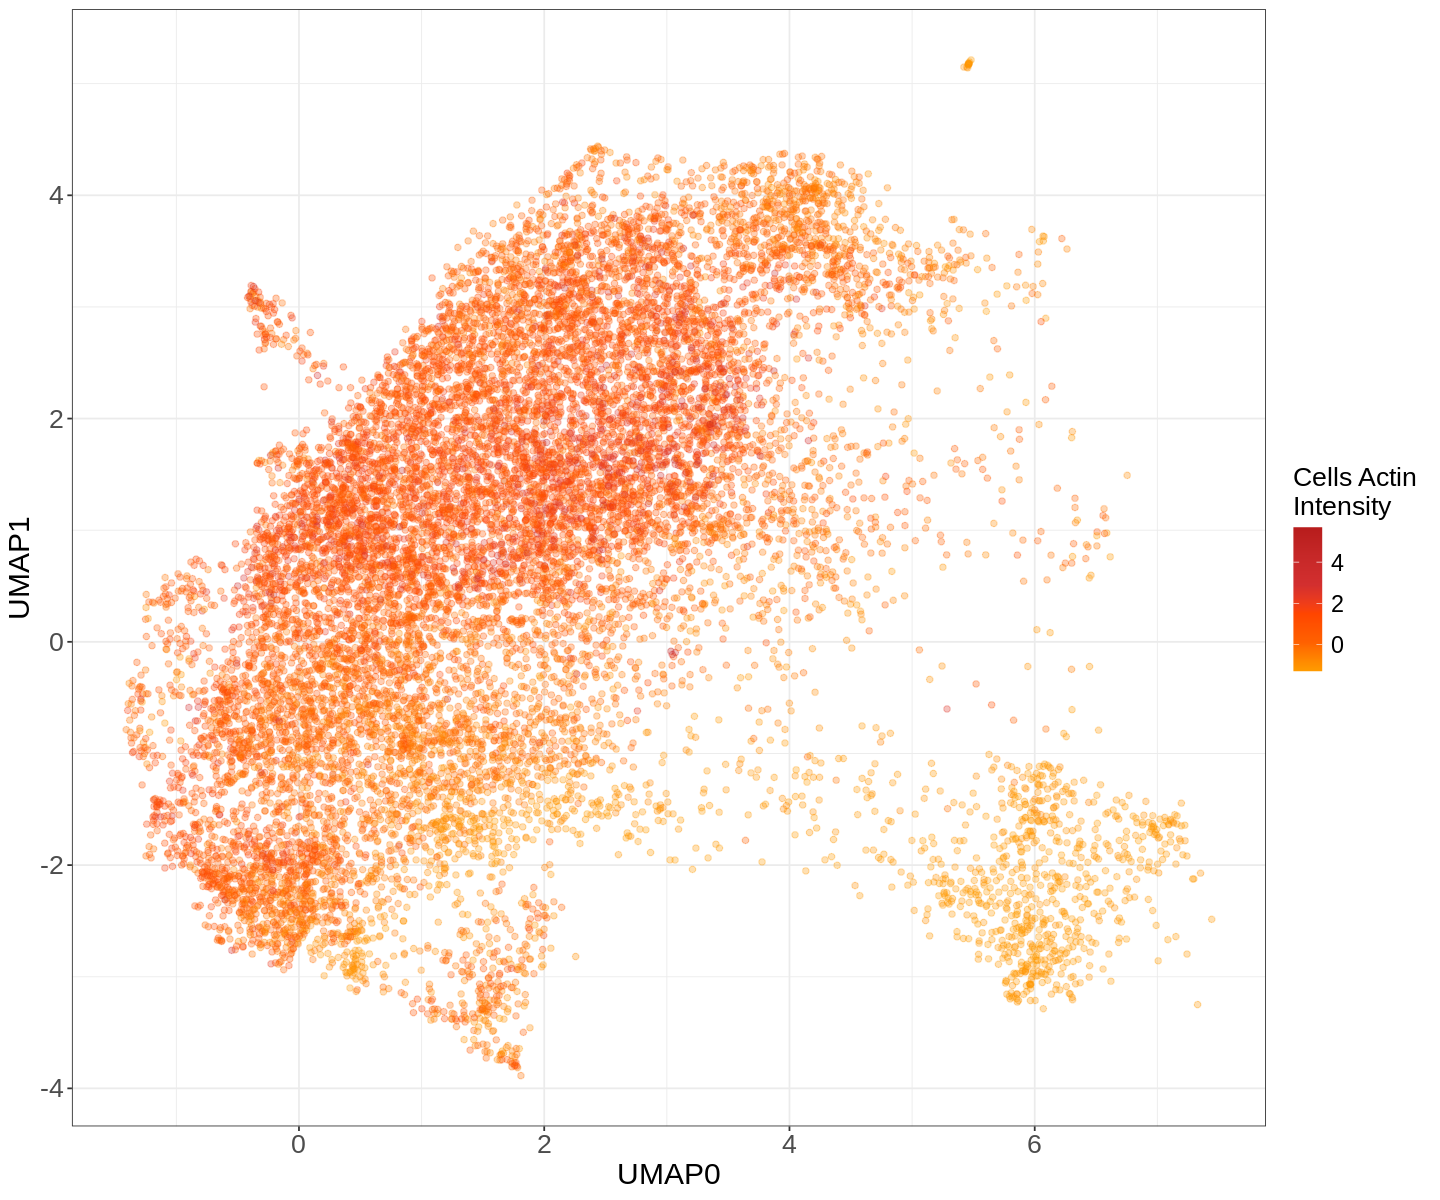

In [7]:
# Generating UMAPs 
options(repr.plot.width = 12, repr.plot.height = 10)  # Adjust width and height as desired
output_file <- paste0(output_umap_file, "_top_actin_feature.png")

umap <- ggplot(combined_df, aes(x = UMAP0, y = UMAP1, color = Cells_Intensity_IntegratedIntensityEdge_Actin)) +
  geom_point(alpha = 0.3) +  # Set alpha for transparency
  scale_color_gradientn(
    colors = c("#FF9C00", "#FF6100", "#FF4500", "#D32F2F", "#C62828", "#B71C1C"), 
    limits = c(min(combined_df$Cells_Intensity_IntegratedIntensityEdge_Actin), 
               max(combined_df$Cells_Intensity_IntegratedIntensityEdge_Actin)),  # Set custom limits
    oob = scales::squish  # Ensure out-of-bound values are squished into the limits
  ) +  # Color gradient for continuous data
  labs(x = "UMAP0", y = "UMAP1", color = "Cells Actin\nIntensity") +
  theme_bw() +
  theme(
    legend.position = "right",  # Position of the legend
    axis.title = element_text(size = 18),  # Increase axis title font size
    axis.text = element_text(size = 16),  # Increase axis text font size
    legend.title = element_text(size = 16),  # Increase legend title font size
    legend.text = element_text(size = 14),  # Increase legend text font size
    plot.title = element_text(size = 20, hjust = 0.5)  # Optional: center-align title with larger size
  )

# Save the plot
ggsave(output_file, umap, dpi = 500, height = 10, width = 12)

umap